In [1]:
import pandas as pd
import numpy as np

from scipy.stats import skew

%matplotlib notebook

In [2]:
house_train = pd.read_csv("/home/aeb/Documents/mlproj/mlproj/train.csv")
house_test = pd.read_csv("/home/aeb/Documents/mlproj/mlproj/test.csv")
house_all = pd.concat((house_train, house_test))

In [3]:
numerical_features = house_all.select_dtypes(include=["float", "int", "bool"]).columns.values
categorical_features = house_all.select_dtypes(include=["object"]).columns.values

In [4]:
numerical_features, categorical_features

(array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
        'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea',
        'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id',
        'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF',
        'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF',
        'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice',
        'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF',
        'YearBuilt', 'YearRemodAdd', 'YrSold'], dtype=object),
 array(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1',
        'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st',
        'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional',
        'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating',
        'HeatingQC', 'House

In [5]:
SKEWNESS_CUTOFF = 0.75

skewed_features = house_train[numerical_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > SKEWNESS_CUTOFF]
skewed_features = skewed_features.index

house_all[skewed_features] = np.log1p(house_all[skewed_features])

In [6]:
house_all = pd.get_dummies(house_all)

In [7]:
house_all = house_all.fillna(house_all.mean())

In [8]:
train_data = house_all[:house_train.shape[0]]
test_data = house_all[house_train.shape[0]:]

test_data = test_data.drop('SalePrice', axis=1)

In [9]:
train_vals = train_data.SalePrice
train_data = train_data.drop('SalePrice', axis=1)

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [11]:
def rmse_crossval(model):
    return np.sqrt(-cross_val_score(model,
                                    train_data,
                                    train_vals,
                                    scoring="neg_mean_squared_error",
                                    cv = 5))

In [12]:
ridge_model = Ridge()

In [13]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
ridges = [rmse_crossval(Ridge(alpha = alpha)).mean() for alpha in alphas]

In [14]:
lalphas = [1, 0.1, 0.001, 0.0005]
lasso_model = LassoCV(alphas = lalphas).fit(train_data, train_vals)

<IPython.core.display.Javascript object>


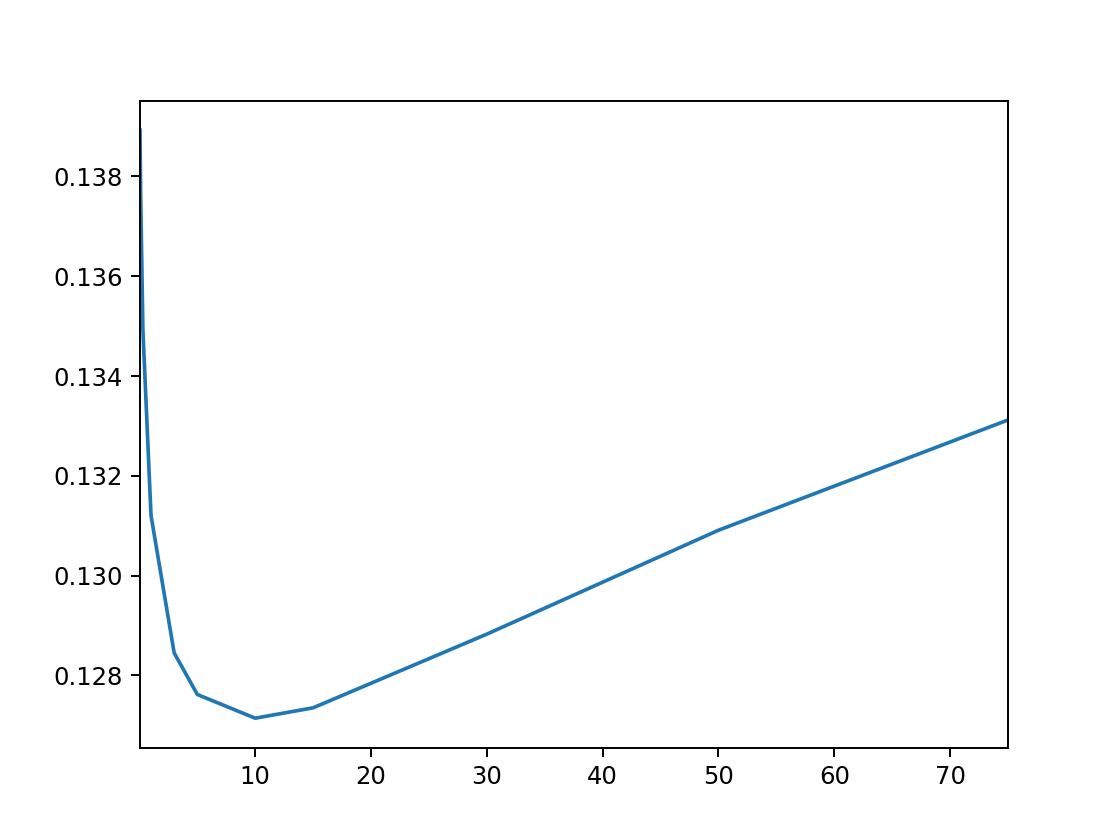

In [15]:
pd.Series(ridges, index = alphas).plot()

In [16]:
rmse_crossval(lasso_model).mean()

0.12305677179517771

In [17]:
coef = pd.Series(lasso_model.coef_, index = train_data.columns)

In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 113 variables and eliminated the other 176 variables


<IPython.core.display.Javascript object>


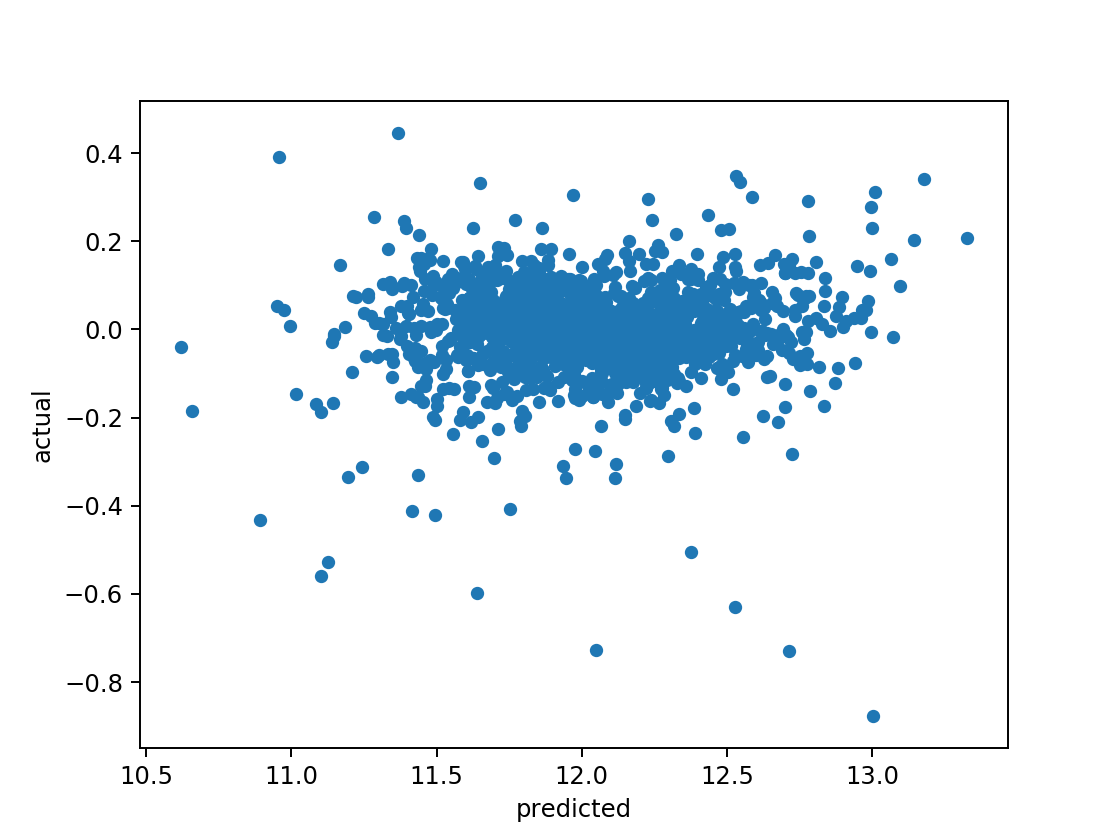

In [20]:
pd.DataFrame({"predicted": lasso_model.predict(train_data),
              "actual": train_vals - lasso_model.predict(train_data)}).plot(x="predicted", y="actual", kind="scatter")

In [24]:
from sklearn.svm import SVR

In [26]:
svr_model = SVR()

In [27]:
svr_model.fit(train_data, train_vals).predict(train_data)

array([ 12.14820612,  12.02874714,  12.21693963, ...,  12.39287427,
        11.9642124 ,  12.00142293])

<IPython.core.display.Javascript object>


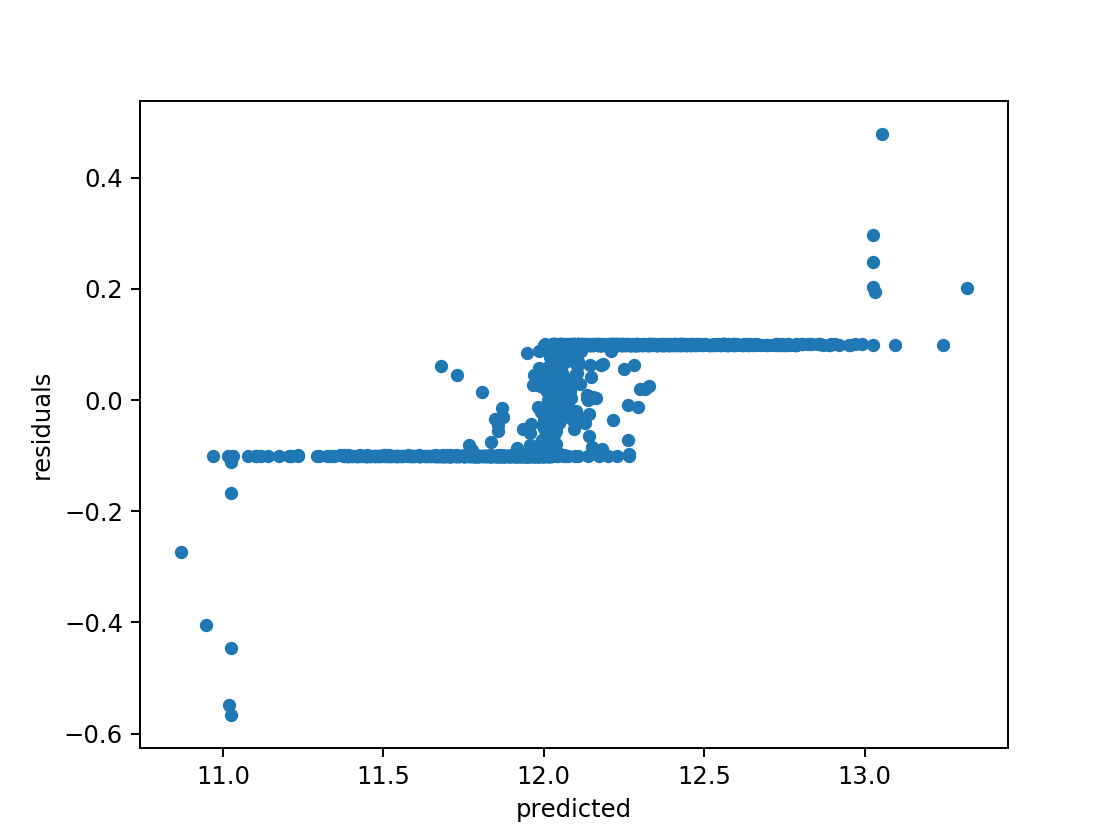

In [30]:
svr_predictions = svr_model.fit(train_data, train_vals).predict(train_data)

pd.DataFrame({"predicted": svr_predictions,
              "residuals": train_vals - svr_predictions}).plot(x="predicted", y="residuals", kind="scatter")

In [32]:
rmse_crossval(svr_model)

array([ 0.38615521,  0.42463368,  0.40951545,  0.38277199,  0.39108948])